In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
# from scipy.spatial import distance
# from scipy import spatial
# from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy

In [2]:
file = r'Gaia_plx7_dr2.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
#print('Succesfully Read in the Data')

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (96,122,130) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source'

In [3]:
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
J_unc = df['j_msigcom']
H_unc = df['h_msigcom']
K_unc = df['ks_msigcom']
# Other Important Data
plx = df["parallax"].values
Dist = 1000./plx
K_er = df["ks_msigcom"].values
J_er = df['j_msigcom']
H_er = df['h_msigcom']
G_flux = df["phot_g_mean_flux"]
G_flux_er = df["phot_g_mean_flux_error"]
GB_flux = df['phot_bp_mean_flux']
GB_flux_er = df['phot_bp_mean_flux_error']
GR_flux = df['phot_rp_mean_flux']
GR_flux_er = df['phot_rp_mean_flux_error']

In [4]:
def ColorClassification(Gmags,Kmags,colors):    
    #assign the stars into different categories based on G-K
    
    #Variables Read In
    #Gmags: numpy array of absolute magnitudes in G
    #Kmags: numpy array of absolute magnitudes in K
    #colors: list or array of values of G-K in increasing order
    
    #Variables Returned
    #color: numpy array that indicates the category of G-K that each star belongs to
    
    #caclculate the values of G-K for all stars
    
    G_K = Gmags-Kmags
    
    #create array to hold the G-K color categories 
    color = np.ones(len(G_K))*1000
    
    #compare the value of G-K for each star to the categories and assign a corresponding
    #value for the category in the color array
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [5]:
def CreateTemplates(color,colors,Gmags,Kmags,GB_mags=[999],GR_mags=[999],J_mags=[999],H_mags=[999],umags=[999],gmags=[999],rmags=[999],imags=[999],zmags=[999]):
    #For each category of G-K, a template is created of the absolute magnitudes of the stars and their color indices 
    #calculated with bands of different magnitudes
    # ** Gmags and Kmags is REQUIRED ** 
    #Variables Read In:
    #color: numpy array that indicates the category of G-K that each star belongs to
    #colors: list or array of values of G-K in increasing order
    #GBmags: numpy array of absolute magnitudes in GB
    #GRmags: numpy array of absolute magnitudes in GR
    #Gmags: numpy array of absolute magnitudes in G
    #Jmags: numpy array of absolute magnitudes in J
    #Hmags: numpy array of absolute magnitudes in H 
    #Kmags: numpy array of absolute magnitudes in K
    #umags: numpy array of absolute magnitudes in u
    #gmags: numpy array of absolute magnitudes in g
    #rmags: numpy array of absolute magnitudes in r
    #imags: numpy array of absolute magnitudes in i
    #zmags: numpy array of absolute magnitudes in z
    
    #Variables Returned: 
    #stars: array of the number of stars in each category of G-K
    #color_mags: array of the color indices at each wavelength for all of the categories of G-K
    #color_std: array of the standard deviation of color indices at each wavelength for all of the categories of G-K
    #color_std_err: array of the standard deviation error of thecolor indices at each wavelength for all of the categories of G-K
    #abs_color_mags: array of the average absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std: array of the standard deviation of absolute magnitudes in each band for all of the categories of G-K
    #abs_color_std_err: array of the standard deviation error of absolute magnitudes in each band for all categores of G-K
    
    if(len(GB_mags) < 2):
        GB_mags = np.ones(len(Gmags))*np.nan
    if(len(GR_mags) < 2):
        GR_mags = np.ones(len(Gmags))*np.nan
    if(len(J_mags) < 2):
        J_mags = np.ones(len(Gmags))*np.nan
    if(len(H_mags) < 2):
        H_mags = np.ones(len(Gmags))*np.nan
    if(len(umags) < 2):
        umags = np.ones(len(Gmags))*np.nan
    if(len(gmags) < 2):
        gmags = np.ones(len(Gmags))*np.nan
    if(len(zmags) < 2):
        zmags = np.ones(len(Gmags))*np.nan
    if(len(imags) < 2):
        imags = np.ones(len(Gmags))*np.nan
    if(len(rmags) < 2):
        rmags = np.ones(len(Gmags))*np.nan
    
    
    #Calculate the values of G-K for each star
    G_K = Gmags-Kmags
    
    #create array to hold the number of stars in each template: 
    stars = np.array([])
    
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_GB_array = np.array([])
        G_GR_array = np.array([])
        G_J_array = np.array([])
        G_H_array = np.array([])
        G_K_array = np.array([])
        G_u_array = np.array([])
        G_g_array = np.array([])
        G_r_array = np.array([])
        G_i_array = np.array([])
        G_z_array = np.array([])
        GB = np.array([])
        GR = np.array([])
        G = np.array([])
        J = np.array([])
        H = np.array([])
        K = np.array([])
        u = np.array([])
        g = np.array([])
        r = np.array([])
        i_m = np.array([])
        z = np.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(Gmags)):
            if (color[i] == c):
                
                G_GB_array = np.append(G_GB_array,Gmags[i]-GB_mags[i])
                G_GR_array = np.append(G_GR_array,Gmags[i]-GR_mags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-J_mags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-H_mags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                G_u_array = np.append(G_u_array,Gmags[i]-umags[i])
                G_g_array = np.append(G_g_array,Gmags[i]-gmags[i])
                G_r_array = np.append(G_r_array,Gmags[i]-rmags[i])
                G_i_array = np.append(G_i_array,Gmags[i]-umags[i])
                G_z_array = np.append(G_z_array,Gmags[i]-zmags[i])
                GB = np.append(GB,GB_mags[i])
                GR = np.append(GR,GR_mags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,J_mags[i])
                H = np.append(H,H_mags[i])
                K = np.append(K,Kmags[i])
                u = np.append(u,umags[i])
                g = np.append(g,umags[i])
                r = np.append(r,rmags[i])
                i_m = np.append(i_m,imags[i])
                z = np.append(z,zmags[i])
                star_count = star_count +1
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.nanmean(G_u_array),np.nanmean(G_g_array), np.nanmean(G_GB_array),\
                     np.nanmean(G_r_array),np.nanmean(G_i_array), np.nanmean(G_GR_array), \
                     np.nanmean(G_z_array),np.nanmean(G_J_array), np.nanmean(G_H_array), \
                     np.nanmean(G_K_array)]
        std_array = [np.nanstd(G_u_array),np.nanstd(G_g_array), np.nanstd(G_GB_array),\
                     np.nanstd(G_r_array),np.nanstd(G_i_array), np.nanstd(G_GR_array), \
                     np.nanstd(G_z_array),np.nanstd(G_J_array), np.nanstd(G_H_array), \
                     np.nanstd(G_K_array)]
        #absolute SED
        mag_array2 = [np.nanmean(u), np.nanmean(g), np.nanmean(GB), \
                      np.nanmean(r), np.nanmean(G), np.nanmean(i), \
                      np.nanmean(GR), np.nanmean(z), np.nanmean(J), \
                      np.nanmean(H), np.nanmean(K)]
        std_array2 = [np.nanstd(u), np.nanstd(g), np.nanstd(GB), \
                      np.nanstd(r), np.nanstd(G), np.nanstd(i_m), \
                      np.nanstd(GR), np.nanstd(z), np.nanstd(J), \
                      np.nanstd(H), np.nanstd(K)]
        #calculate standard deviation error
        val = np.sqrt(len(G_u_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(u))
        std_array4 = std_array2/val2
        #stack SEDs
        if (c == colors[0]):
            
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            #print(len(color_mags),len(mag_array))
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            #print('\n',len(abs_color_mags),len(mag_array2))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
            #A[~np.isnan(A)])
    #print((color_mags))
#     color_mags = color_mags[~np.isnan(color_mags)]
#     #print(len(color_mags))
#     color_std = color_std[~np.isnan(color_std)]
#     color_std_err = color_std_err[~np.isnan(color_std_err)]
#     abs_color_mags = abs_color_mags[~np.isnan(abs_color_mags)]
#     abs_color_std = abs_color_std[~np.isnan(abs_color_std)]
#     abs_color_std_err = abs_color_std_err[~np.isnan(abs_color_std_err)]
#     color_mags = np.reshape(color_mags, (-1, 10))
#     color_std = np.reshape(color_std, (-1, 10))
#     color_std_err = np.reshape(color_std_err, (-1, 10))
#     print(color_mags,'\n',abs_color_mags)
#     abs_color_mags = np.reshape(abs_color_mags, (-1, 11))
#     abs_color_std = np.reshape(abs_color_std, (-1, 11))
#     abs_color_std_err = np.reshape(abs_color_std_err, (-1, 11))
            
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [6]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
GK = Gmag - Kmag
br_Gmag = []
br_Gflux = []
br_Gflux_er = []
br_GBmag = []
br_GBflux = []
br_GBflux_er = []
br_GRmag = []
br_GRflux = []
br_GRflux_er = []
br_Jmag = []
br_Hmag = []
br_Kmag = []
br_GK = []
br_G = []
J_unc_br = []
H_unc_br = []
K_unc_br = []
for i in range(len(Gmags)):
    if(Gmags[i] < 10 and GK[i] >= 1.0 and GK[i] <= 4.0):
    #if(SNR[i] > 50):
        br_Gmag.append(Gmag[i])
        br_GBmag.append(GBmag[i])
        br_GRmag.append(GRmag[i])
        br_Jmag.append(Jmag[i])
        br_Hmag.append(Hmag[i])
        br_Kmag.append(Kmag[i])
        br_GK.append(GK[i])
        br_G.append(Gmags[i])
        br_Gflux.append(G_flux[i])
        br_Gflux_er.append(G_flux_er[i])
        br_GBflux.append(GB_flux[i])
        br_GBflux_er.append(GB_flux_er[i])
        br_GRflux.append(GR_flux[i])
        br_GRflux_er.append(GR_flux_er[i])
        J_unc_br.append(J_unc[i])
        H_unc_br.append(H_unc[i])
        K_unc_br.append(K_unc[i])
    
br_Gmag = np.array(br_Gmag)
br_GBmag = np.array(br_GBmag)
br_GRmag = np.array(br_GRmag)
br_Jmag = np.array(br_Jmag)
br_Hmag = np.array(br_Hmag)
br_Kmag = np.array(br_Kmag)
br_Gflux = np.array(br_Gflux)
br_Gflux_er = np.array(br_Gflux_er)
br_GBflux = np.array(br_GBflux)
br_GBflux_er = np.array(br_GBflux_er)
br_GRflux = np.array(br_GRflux)
br_GRflux_er = np.array(br_GRflux_er)
br_GK = np.array(br_GK)
br_G = np.array(br_G)
all_BrightStars = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
print('Length of Br_Mags:',len(br_Gmag))

dm_G = []
dm_Gmag = []
dm_GBmag = []
dm_GRmag = []
dm_Jmag = []
dm_Hmag = []
dm_Kmag = []
dm_GK = []
dm_Gflux = []
dm_Gflux_er = []
dm_GBflux = []
dm_GBflux_er = []
dm_GRflux = []
dm_GRflux_er = []
J_unc_dm = []
H_unc_dm = []
K_unc_dm = []
for i in range(len(Gmags)):
    if(Gmags[i] > 10 and GK[i] >= 1.0 and GK[i] <= 4.0):
        dm_Gmag.append(Gmag[i])
        dm_GBmag.append(GBmag[i])
        dm_GRmag.append(GRmag[i])
        dm_Jmag.append(Jmag[i])
        dm_Hmag.append(Hmag[i])
        dm_Kmag.append(Kmag[i])
        dm_GK.append(GK[i])
        dm_G.append(Gmags[i])
        dm_Gflux.append(G_flux[i])
        dm_Gflux_er.append(G_flux_er[i])
        dm_GBflux.append(GB_flux[i])
        dm_GBflux_er.append(GB_flux_er[i])
        dm_GRflux.append(GR_flux[i])
        dm_GRflux_er.append(GR_flux_er[i])
        J_unc_dm.append(J_unc[i])
        H_unc_dm.append(H_unc[i])
        K_unc_dm.append(K_unc[i])

dm_Gflux = np.array(dm_Gflux)
dm_Gflux_er = np.array(dm_Gflux_er)
dm_GBflux = np.array(dm_GBflux)
dm_GBflux_er = np.array(dm_GBflux_er)
dm_GRflux = np.array(dm_GRflux)
dm_GRflux_er = np.array(dm_GRflux_er)
dm_Gmag = np.array(dm_Gmag)
dm_GBmag = np.array(dm_GBmag)
dm_GRmag = np.array(dm_GRmag)
dm_Jmag = np.array(dm_Jmag)
dm_Hmag = np.array(dm_Hmag)
dm_Kmag = np.array(dm_Kmag)
dm_GK = np.array(dm_GK)
dm_G = np.array(dm_G)
all_dimStars = np.transpose([dm_Gmag,dm_GBmag,dm_GRmag,dm_Jmag,dm_Hmag,dm_Kmag])
print('Length of dm_Mags:',len(dm_Gmag))

Length of Br_Mags: 296527
Length of dm_Mags: 279660


In [245]:
BrightStars = np.transpose([br_Gmag,br_GBmag,br_GRmag,br_Jmag,br_Hmag,br_Kmag])
print(BrightStars[0])

FaintS

[10.02853012 10.37783909  9.54774475  8.99300003  8.68599987  8.65100002]


In [ ]:
def StarFitting(starBands,color_mags,color_std):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    template_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    Chi2_vals = []
    for i in range(len(template_bands)):
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(template_err[i,j])**2)
        Chi2 = Chi2/(len(new_starBands)-1)  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            red_Chi2.append(chi_val)
            best_fit = i
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, red_Chi2

In [274]:
Gmags = Gmag - 5 * np.log10(Dist) + 5
#Gmags = Gmag - 5 * np.log10(Dist) + 5
m = np.random.randint(1,len(Gmags))
mag1 = GBmag[m]
#mag2 = Gmag[3]

flux1 = GB_flux[m]
flux1_er = GB_flux_er[m]

n = np.random.randint(1,len(Gmags))

flux2 = GB_flux[n]
flux2_er = GB_flux_er[n]
def MagError(flux1,flux1_er,KnownMag,flux2,flux2_er):
    
    Mag = 2.5*np.log10(flux1/flux2) + KnownMag
    Mag_er = np.sqrt(((2.5/(np.log(10)*flux1))*flux1_er)**2 + ((-2.5/(np.log(10)*flux2))*flux2_er)**2)
    return Mag, Mag_er


if(str(flux1) != 'nan' and str(flux2) != 'nan' and str(flux1_er) != 'nan' and str(flux2_er) != 'nan' and str(mag1) != 'nan'):
    Mag, Mag_er = MagError(flux1,flux1_er,mag1,flux2,flux2_er)
    print(mag1)
    print(flux1,'\n')
    print(GBmag[n])
    print(Mag)
    print(Mag_er)
    print(Gmags[n])
    print(abs(Mag - GBmag[n]))
else:
    print('Error')


20.61830139160156
78.2049987876678 

19.86456680297852
19.864566895549043
0.22284686827576114
14.279217044129886
9.257052369093799e-08


In [305]:
len(GR_unc_br)

296527

In [304]:
GR_unc_br = []
count = 0

for i in range(0,len(br_Gmag)):
    n = np.random.randint(1,len(br_Gmag))
    mag = br_GRmag[0]
    flux1 = br_GRflux[0]
    flux1_er = br_GRflux_er[0]
    flux2 = br_GRflux[i]
    flux2_er = br_GRflux_er[i]
    #if(str(flux1) != 'nan' and str(flux2) != 'nan' and str(flux1_er) != 'nan' and str(flux2_er) != 'nan' and str(mag1) != 'nan'):
    Mag, Mag_er = MagError(flux1,flux1_er,mag,flux2,flux2_er)
    if(abs(Mag - br_GRmag[i]) < .00001):
        count = count + 1
    GR_unc_br.append(Mag_er)
    Mag1 = Mag
    mag1 = mag
print(br_GBmag[i],Mag1,count)
GR_unc_br = np.array(GR_unc_br)
# plt.hist(GB_unc_br,500)
# plt.hist(G_unc_dm,200,alpha=0.6)
# plt.xlim([0,.03])
# plt.show()
# print(np.median(GB_unc_br))
# print(np.median(G_unc_br))
# print(np.mean(GB_unc_br))   

nan nan 296083


C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


ValueError: max must be larger than min in range parameter.

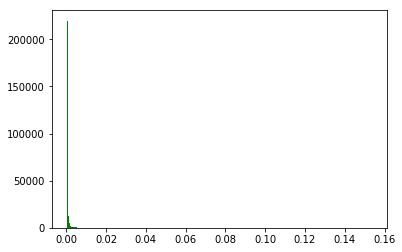

In [300]:
plt.hist(G_unc_br,500,label='G',color='green')
plt.hist(GB_unc_br,500,alpha=0.6,label='GB',color='blue')
plt.hist(GR_unc_br,500,alpha=0.6,label='GR',color='red')
plt.xlim([0,.02])
plt.legend()
plt.show()
print('Mean Star Uncertainty in G:',np.mean(G_unc_br)) 
print('Mean Star Uncertainty in GB:',np.mean(GB_unc_br))
print('Mean Star Uncertainty in GR:',np.mean(GR_unc_br))
print('Median Star Uncertainty in G:',np.median(G_unc_br))
print('Median Star Uncertainty in GB:',np.median(GB_unc_br))
print('Median Star Uncertainty in GR:',np.median(GR_unc_br))
print(np.nanmean(J_unc))

In [306]:
print(len(G_unc_br),len(GB_unc_br),len(GR_unc_br),len(J_unc_br),len(H_unc_br),len(K_unc_br))

296527 296527 296527 296527 296527 296527


In [498]:
def StarFit(starBands,color_mags,star_err):
    new_starBands = []
    for i in range(len(starBands)):
        if(i == 0):
            G = starBands[i]
        else:
            G_X = G - starBands[i]
            new_starBands.append(G_X)
    
    template_bands = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        template_bands.append(cm)
    template_bands = np.array(template_bands)
    
    newStar_err = []
    for i in range(len(star_err)):
        if(i == 0):
            sigmaG = star_err[i]
        else:
            sigma = star_err[i]
            newStar_err.append(np.sqrt(sigmaG**2+sigma**2))
    newStar_err = np.array(newStar_err)
    Chi2_vals = []
    for i in range(len(template_bands)):
        #Chi2 = ((template_bands[i] - new_starBands)**2/(newStar_err)**2)
        #Chi2 = np.sum(Chi2)
        Chi2 = 0
        for j in range(len(new_starBands)):
            Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(star_err[j])**2)
        Chi2 = Chi2/(len(template_bands))  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    Chi2_vals = np.array(Chi2_vals)
    
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi_val = Chi2_vals[i]
            
            #red_Chi2.append(chi_val)
            best_fit = i
#             print('The best Template is '+ str((best_fit+1)) +' out of '+str(len(template_bands))+ ' templates')
#             print('Or ' + str(best_fit) + ' out of ' + str((len(template_bands)-1)))
    #print(best_fit)
    return best_fit, new_starBands, newStar_err, chi_val

In [242]:
colors = np.arange(1,4,0.03) # EDIT THIS TO USE DESIRED NUMBER OF COLORS

# BRIGHT STARS
color_br = ColorClassification(br_Gmag,br_Kmag,colors)

stars_br,color_mags_br,color_std_br,color_std_err_br,abs_color_mags_br,abs_color_std_br,abs_color_std_err_br = \
CreateTemplates(color_br,colors,Gmags=br_Gmag,Kmags=br_Kmag,GB_mags=br_GBmag,GR_mags=br_GRmag,J_mags=br_Jmag,H_mags=br_Hmag)

# DIM STARS
color_dm = ColorClassification(dm_Gmag,dm_Kmag,colors)

stars_dm,color_mags_dm,color_std_dm,color_std_err_dm,abs_color_mags_dm,abs_color_std_dm,abs_color_std_err_dm = \
CreateTemplates(color_dm,colors,dm_Gmag,dm_Kmag,GB_mags=dm_GBmag,GR_mags=dm_GRmag,J_mags=dm_Jmag,H_mags=dm_Hmag)

C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: Mean of empty slice
C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: RuntimeWarning: Mean of empty slice


In [419]:
star_err = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
idx = np.random.randint(1,len(br_Gmag))
print(star_err[idx])

[0.00056419 0.00219814 0.00206031 0.026      0.026      0.025     ]


[        nan         nan -0.37493596         nan         nan  0.51558091
         nan  1.11446042  1.44509189  1.52460492]
[0.00304892 0.00330058 0.02302834 0.04701387 0.01903429]

Reduced X^2 for Bright Template Fit: 1.6930601934633103
Reduced X^2 for Faint Template Fit: 179.83269358327388


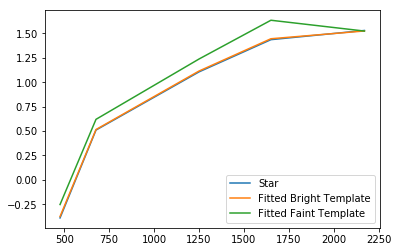

In [502]:
mags = copy.copy(color_mags_br)
mags = mags[1:len(mags)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]
star_err = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
idx = np.random.randint(1,len(br_Gmag))
starBand = all_BrightStars[idx]
starBand = np.array(starBand)
starBand = starBand[~np.isnan(starBand)]
starError = star_err[idx]
starError = starError[~np.isnan(starError)]

if(len(starBand) == len(all_BrightStars[idx]) and len(starError) == len(star_err[idx])):
    
    fit, newBands, newStar_err, chi2 = StarFit(starBand,mags,starError)
    fit2, newBands, newStar_err2, chi2_2 = StarFit(starBand,mags_dm,starError)
print(mags[fit])
print(newStar_err)
wvl = [477,677,1250,1650,2170]
print('\nReduced X^2 for Bright Template Fit:', chi2)
print('Reduced X^2 for Faint Template Fit:', chi2_2)
mag2 = copy.copy(mags[fit])
mag2 = mag2[~np.isnan(mag2)]
mag3 = copy.copy(mags_dm[fit2])
mag3 = mag3[~np.isnan(mag3)]
plt.plot(wvl,newBands,label='Star')
plt.plot(wvl,mag2,label='Fitted Bright Template')
plt.plot(wvl,mag3,label='Fitted Faint Template')
plt.legend()
plt.show()

#print('Reduced X^2 Value for StarFitting:', chi2)

In [ ]:
star_err_br = np.transpose([G_unc_br,GB_unc_br,GR_unc_br,J_unc_br,H_unc_br,K_unc_br])
mags_br = copy.copy(color_mags_br)
mags_br = mags[1:len(mags_br)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]

BrightTempFits = 0
FaintTempFits = 0
for i in range(len(br_Gmag)):
    starBand = all_BrightStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_BrightStars[i]) and len(starError) == len(star_err_br[i])):
        fit_br, newBands, newStar_err, chi2_br = StarFit(starBand,mags_br,starError)
        fit_br, newBands, newStar_err, chi2_dm = StarFit(starBand,mags_dm,starError)
        if(chi2_br < chi2_dm):
            BrightTempFits = BrightTempFits + 1
        if(chi2_dm < chi2_br):
            FaintTempFits = FaintTempFits + 1
            
print('Percentage of Fits On to Bright Templates:' + str(100*(BrightTempFits/len(all_BrightStars))))
print('Percentage of Fits On to Faint Templates:' + str(100*(FaintTempFits/len(all_BrightStars))))

In [ ]:
star_err_dm = np.transpose([G_unc_dm,GB_unc_dm,GR_unc_dm,J_unc_dm,H_unc_dm,K_unc_dm])
mags_br = copy.copy(color_mags_br)
mags_br = mags[1:len(mags_br)]
mags_dm = copy.copy(color_mags_dm)
mags_dm = mags_dm[1:len(mags_dm)]

BrightTempFits = 0
FaintTempFits = 0
for i in range(len(dm_Gmag)):
    starBand = all_dimStars[i]
    starBand = np.array(starBand)
    starBand = starBand[~np.isnan(starBand)]
    starError = star_err_br[i]
    starError = starError[~np.isnan(starError)]
    if(len(starBand) == len(all_dimStars[i]) and len(starError) == len(star_err_dm[i])):
        fit_br, newBands, newStar_err, chi2_br = StarFit(starBand,mags_br,starError)
        fit_br, newBands, newStar_err, chi2_dm = StarFit(starBand,mags_dm,starError)
        if(chi2_br < chi2_dm):
            BrightTempFits = BrightTempFits + 1
        if(chi2_dm < chi2_br):
            FaintTempFits = FaintTempFits + 1
            
print('Percentage of Fits On to Bright Templates:' + str(100*(BrightTempFits/len(all_BrightStars))))
print('Percentage of Fits On to Faint Templates:' + str(100*(FaintTempFits/len(all_BrightStars))))